In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# sns.set_style('white')
sns.set_style('darkgrid')
sns.set_context("paper", font_scale = 1)

plt.rc('font', family='serif')

plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', title_fontsize='small', fontsize='small')


plt.rcParams['svg.fonttype'] = 'none'

In [3]:
dataset = pd.read_pickle('../../geodata/results/01_master_building_dataset.pkl')
# dataset = pd.read_pickle('../../../geodata/results/01_master_building_dataset.pkl')


In [4]:
maxvsh_cols    = dataset.columns[dataset.columns.str.contains('maxvsh')].tolist()
vaccess_cols   = dataset.columns[dataset.columns.str.contains('vwa')].tolist()
# mean_cols      = dataset.columns[dataset.columns.str.contains('mn')].tolist()
dist_cols      = dataset.columns[dataset.columns.str.contains('sum_')].tolist()
vconfig_cols   = np.setdiff1d(dataset.columns[np.where(dataset.columns == 'snt_0')[0][0]:np.where(dataset.columns == 'cmpx_gini')[0][0]+1].tolist(),dist_cols).tolist()
id_cols        = ['ID_Geb','Stockwerk','FassPktX','FassPktY','FassPktZ']

dataset['unit_pano'] = dataset['unit_pano'].fillna(0)

In [5]:
import joblib
xgb_model   = joblib.load("../../geodata/results/t10agglo_models/tr292ts73_XGB.joblib")
# xgb_model   = joblib.load("../../../geodata/results/t10agglo_models/tr292ts73_XGB.joblib")
model_feats    = maxvsh_cols+vaccess_cols+vconfig_cols+dist_cols

scaler_4model   = joblib.load("../../geodata/results/scaler_for_model.joblib")
# scaler_4model   = joblib.load("../../../geodata/results/scaler_for_model.joblib")

X = dataset.copy()
X[model_feats] = scaler_4model.transform(dataset[model_feats])

dataset['XGB'] = xgb_model.predict(X[xgb_model.feature_names_in_])
dataset = dataset.reset_index()


In [6]:
sel_10agglo_lst = dataset.groupby(['Agglo_Name','Rich_Nabr'])['GMDNR'].size().unstack().sort_values(by = 'R', ascending = False).head(10).index.tolist()
dat = (dataset.query('Stockwerk < 5')
            .query('tprsn >= 100')
            .query('net_income_ptp < 500')
            .query('Agglo_Name in @sel_10agglo_lst')
        ).reset_index()
X = dat.copy()
X[model_feats] = scaler_4model.transform(dat[model_feats])



In [161]:
rename_col = {
    'maxvsh_Gew1':  'maxVSH: WaterBodies',
    'sum_ShFer3':   'meanVSH: Far Dist',
    'maxvsh_Nat3':  'maxVSH: Nature',
    'sum_ShMit2':   'meanVSH: Mid Dist',
    'maxvsh_Lan10': 'maxVSH: Agriculture',
    'maxvsh_Geb12': 'maxVSH: Buildings',
    'maxvsh_Veg3':  'maxVSH: Vegetation',
    'vwa_Gew1':     'VA: WaterBodies',
    "maxvsh_Was16": 'maxVSH: WaterBasin',
    "dist_gini":    'Ineq: Dist',
    "sum_ShSky":   'meanVSH: Sky',
    "maxvsh_sky":   'maxVSH: Sky',
}
dat_sampled = dat_sampled.rename(columns = rename_col)

In [25]:
import shap

rand_ix = list(np.random.randint(0,X.shape[0],100000))
X_sampled = pd.DataFrame(X.loc[rand_ix,xgb_model.feature_names_in_])
dat_sampled = pd.DataFrame(dat.loc[rand_ix,xgb_model.feature_names_in_])
# X_sampled = pd.DataFrame(dataset.loc[:,feat_names].sample(100000))

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(dat_sampled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


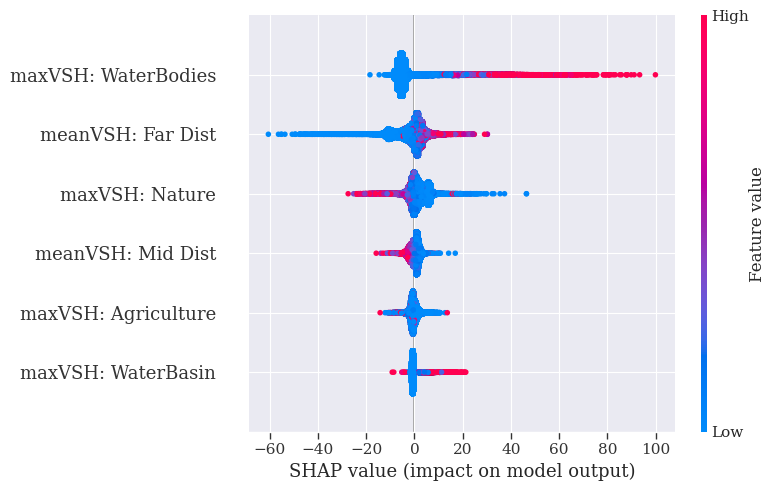

In [165]:
shap.summary_plot(shap_values, dat_sampled, max_display=6, show=False,plot_size=[8,5])

plt.savefig('../../figs/fig4_shap_summary.jpg',bbox_inches = 'tight')


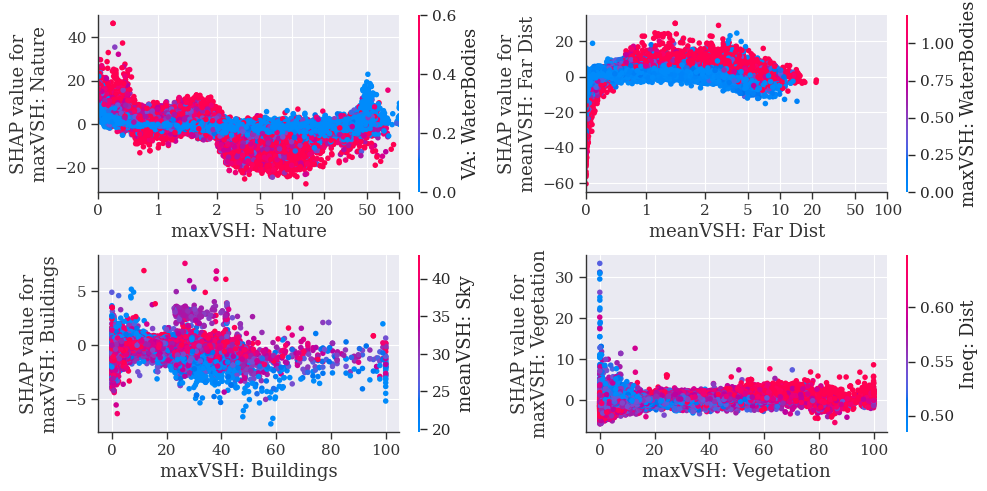

In [164]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
ax = ax.flatten()
shap.dependence_plot(rename_col["sum_ShFer3"], 
                     shap_values, dat_sampled,
                     show=False, interaction_index=rename_col['maxvsh_Gew1'], 
                     ax = ax[1])


shap.dependence_plot(rename_col["maxvsh_Nat3"], 
                     shap_values, dat_sampled,
                     show=False, ax = ax[0],)

shap.dependence_plot(rename_col["maxvsh_Geb12"], 
                     shap_values, dat_sampled,
                     show=False, 
                     interaction_index=rename_col['sum_ShSky'],
                     ax = ax[2])
shap.dependence_plot(rename_col["maxvsh_Veg3"], 
                     shap_values, dat_sampled,
                     show=False, 
                     interaction_index=rename_col['dist_gini'],
                     ax = ax[3])
for axx in ax[:2]:
    axx.set_xlim(0,100)
    axx.set_xscale('symlog')

    axx.tick_params(axis = 'both', which = 'major', bottom=True, left = True)

    axx.set_xticks([0,1,2,5,10,20,50,100])
    x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
    axx.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# plt.gca().xaxis.set_minor_locator(x_minor)

plt.tight_layout()
plt.savefig('../../figs/fig4_shap_interaction_2x2.jpg',bbox_inches = 'tight')


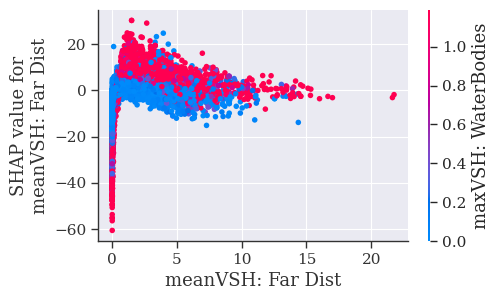

In [159]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,3))

# shap.summary_plot(shap_values, dat, max_display=5, show=False, ax = axes[0])
shap.dependence_plot(rename_col["sum_ShFer3"], shap_values, dat_sampled,show=False, interaction_index=rename_col['maxvsh_Gew1'], ax = axes)
# shap.dependence_plot(rename_col["maxvsh_Veg3"], shap_values, dat_sampled,show=False, interaction_index=rename_col['vwa_Gew1'], ax = axes[1])

# axes.set_xlabel('meanVSH (%) of Elements in Far Dist')
# axes.set_ylabel('SHAP value')


# axes[1].set_xlabel('maxVSH of Vegetation (%)')
# axes[1].set_ylabel('SHAP value')


plt.savefig('../../figs/fig4_shap_interaction_1.jpg',bbox_inches = 'tight')



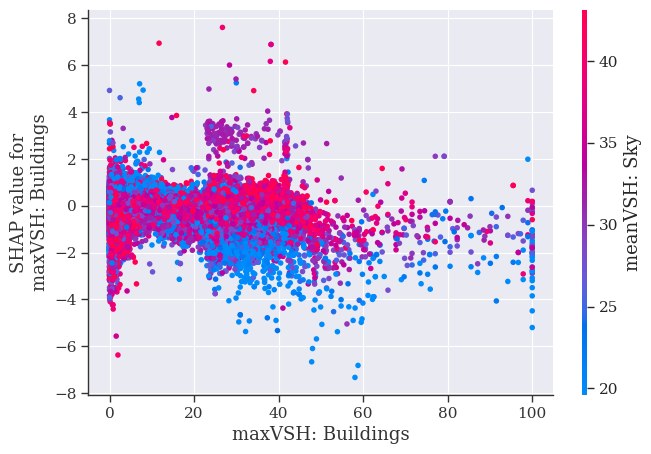

In [162]:
shap.dependence_plot(rename_col["maxvsh_Geb12"], 
                     shap_values, dat_sampled,
                     show=False, 
                     interaction_index=rename_col["sum_ShSky"]
                     )

# plt.xscale('function', functions=(partial(np.power, 1.5), np.logb(1.5)))
# plt.xlim(0,100)
# plt.xscale('symlog')

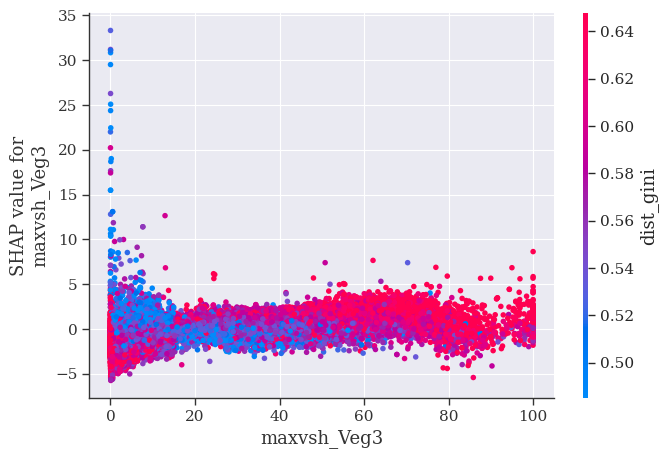

In [135]:
shap.dependence_plot("maxvsh_Veg3", 
                     shap_values, dat_sampled,
                     show=False, 
                     interaction_index='dist_gini'
                     )

# plt.xscale('function', functions=(partial(np.power, 1.5), np.logb(1.5)))
# plt.xlim(0,100)
# plt.xscale('symlog')

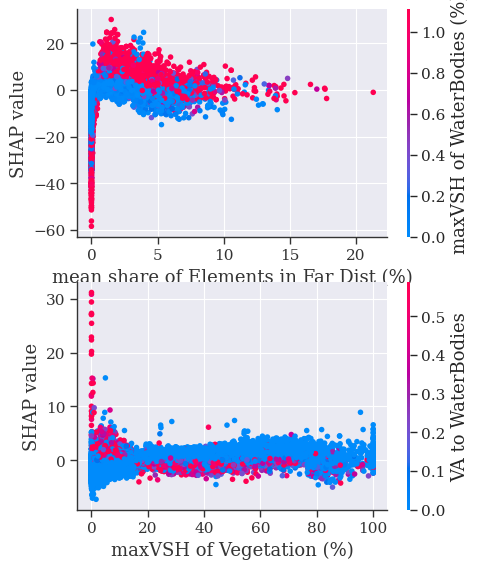

In [168]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5,7.5))

# shap.summary_plot(shap_values, dat, max_display=5, show=False, ax = axes[0])
shap.dependence_plot(rename_col["sum_ShFer3"], shap_values, dat_sampled,show=False, interaction_index=rename_col['maxvsh_Gew1'], ax = axes[0])
shap.dependence_plot(rename_col["maxvsh_Veg3"], shap_values, dat_sampled,show=False, interaction_index=rename_col['vwa_Gew1'], ax = axes[1])

axes[0].set_xlabel('mean share of Elements in Far Dist (%)')
axes[0].set_ylabel('SHAP value')


axes[1].set_xlabel('maxVSH of Vegetation (%)')
axes[1].set_ylabel('SHAP value')


plt.savefig('../../figs/fig4_shap_interaction.jpg',bbox_inches = 'tight')


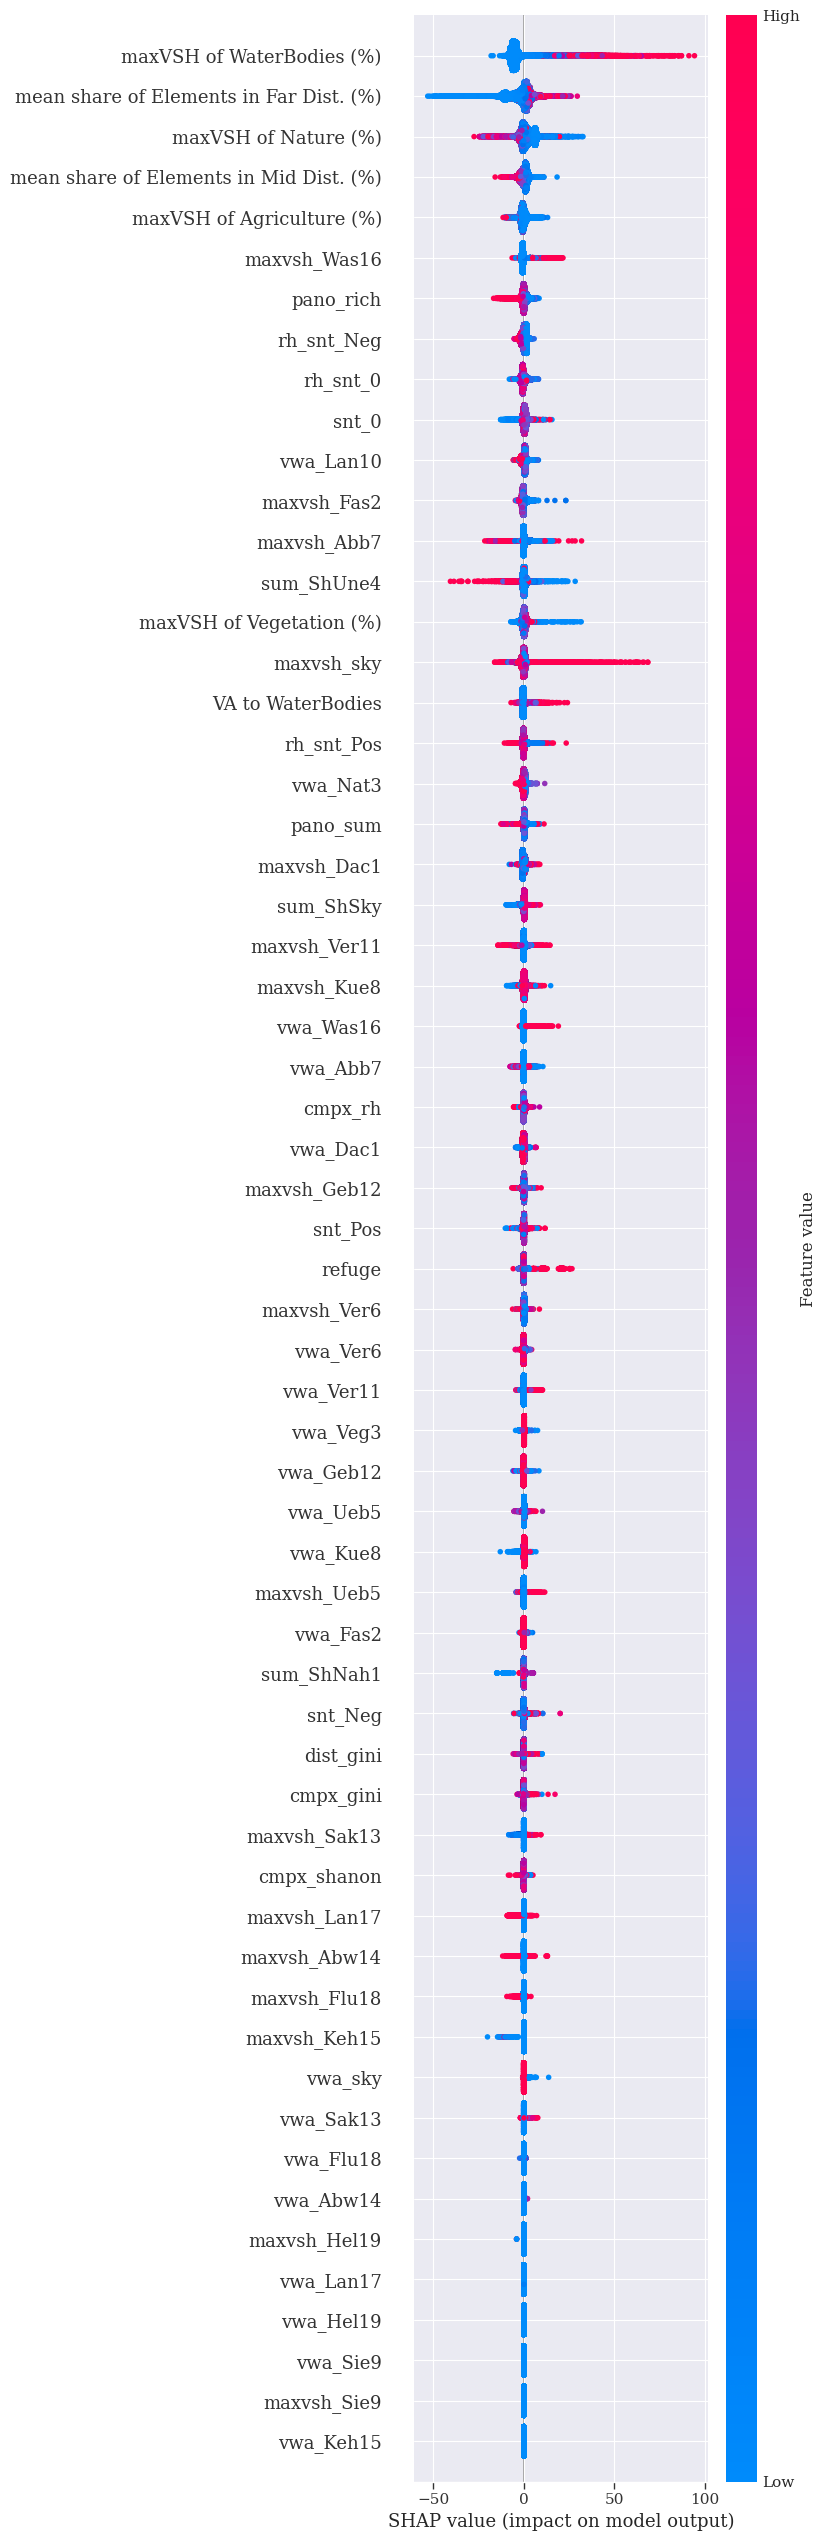

In [12]:
shap.summary_plot(shap_values, dat_sampled, max_display = 65, show=False)
